<a href="https://colab.research.google.com/github/cwilbar04/nba-predictions/blob/main/notebooks/model_data_creation_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.cloud import bigquery_storage
from datetime import datetime
import os
import pyarrow
import firebase_admin
from firebase_admin import credentials as cred
from firebase_admin import firestore

In [117]:
# from google.colab import auth
# auth.authenticate_user()
# print('Authenticated')

In [118]:
my_project_id = "nba-predictions-dev"
raw_game_data_table = 'nba.raw_basketballreference_game'
raw_player_data_table = 'nba.raw_basketballreference_playerbox'

In [119]:
%env GOOGLE_APPLICATION_CREDENTIALS C:\GCP\nba-predictions-dev-d76075f0a064.json

env: GOOGLE_APPLICATION_CREDENTIALS=C:\GCP\nba-predictions-dev-d76075f0a064.json


In [120]:
%env GOOGLE_CLOUD_PROJECT nba-predictions-dev

env: GOOGLE_CLOUD_PROJECT=nba-predictions-dev


In [121]:
credentials = os.environ.get("GOOGLE_APPLICATION_CREDENTIALS")

In [122]:
client = bigquery.Client(project=my_project_id,)

In [8]:
# %%bigquery --project nba-predictions-dev game
#   SELECT * from `nba.raw_basketballreference_game`

In [9]:
# %%bigquery --project nba-predictions-dev player
#   SELECT * from `nba.raw_basketballreference_playerbox`

In [10]:
game = client.query('''
  SELECT
    *
  FROM
    `%s`
''' % (raw_game_data_table)).to_dataframe()

In [11]:
player = client.query('''
  SELECT
    *
  FROM
    `%s`
''' % (raw_player_data_table)).to_dataframe()

In [12]:
game_original = game.copy()
player_original = player.copy()

In [13]:
game[game['game_date']==game['game_date'].max()]

,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,...,h_ff_efg_pct,h_ff_tov_pct,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score
1096,2021-02-26,7:30p,Indiana Pacers,IND,112,Boston Celtics,BOS,118,/boxscores/202102260BOS.html,0,...,.567,10.4,17.9,.305,120.7,2021-02-27 12:00:11+00:00,None,None,None,None
1097,2021-02-26,7:30p,Houston Rockets,HOU,111,Toronto Raptors,TOR,122,/boxscores/202102260TOR.html,0,...,.539,10.6,26.8,.292,122.7,2021-02-27 12:00:12+00:00,None,None,None,None
1098,2021-02-26,8:00p,Phoenix Suns,PHO,106,Chicago Bulls,CHI,97,/boxscores/202102260CHI.html,0,...,.570,16.9,20.6,.089,102.9,2021-02-27 12:00:13+00:00,None,None,None,None
1099,2021-02-26,8:00p,Sacramento Kings,SAC,110,Detroit Pistons,DET,107,/boxscores/202102260DET.html,0,...,.524,10.3,22.2,.256,110.0,2021-02-27 12:00:13+00:00,None,None,None,None
1100,2021-02-26,8:00p,Los Angeles Clippers,LAC,119,Memphis Grizzlies,MEM,99,/boxscores/202102260MEM.html,"2,039",...,.448,8.0,15.7,.124,97.9,2021-02-27 12:00:14+00:00,None,None,None,None
1101,2021-02-26,8:00p,Utah Jazz,UTA,116,Miami Heat,MIA,124,/boxscores/202102260MIA.html,0,...,.593,13.4,28.9,.256,124.4,2021-02-27 12:00:15+00:00,None,None,None,None
1102,2021-02-26,8:00p,Atlanta Hawks,ATL,109,Oklahoma City Thunder,OKC,118,/boxscores/202102260OKC.html,0,...,.614,9.5,12.5,.114,123.0,2021-02-27 12:00:15+00:00,None,None,None,None
1103,2021-02-26,10:00p,Charlotte Hornets,CHO,121,Golden State Warriors,GSW,130,/boxscores/202102260GSW.html,0,...,.677,20.4,13.8,.291,121.1,2021-02-27 12:00:16+00:00,None,None,None,None
1104,2021-02-26,10:00p,Portland Trail Blazers,POR,93,Los Angeles Lakers,LAL,102,/boxscores/202102260LAL.html,0,...,.460,8.2,30.0,.239,109.5,2021-02-27 12:00:17+00:00,None,None,None,None


In [14]:
game.head()

,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,...,h_ff_efg_pct,h_ff_tov_pct,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score
0,2021-01-18,5:00p,Phoenix Suns,PHO,104,Memphis Grizzlies,MEM,108,/boxscores/202101180MEM.html,204,...,.560,14.0,22.0,.181,111.2,2021-02-24 21:26:16+00:00,None,None,None,None
1,2021-01-18,3:00p,San Antonio Spurs,SAS,125,Portland Trail Blazers,POR,104,/boxscores/202101180POR.html,0,...,.489,11.7,18.2,.178,106.7,2021-02-24 21:26:16+00:00,None,None,None,None
2,2021-01-18,7:30p,Dallas Mavericks,DAL,93,Toronto Raptors,TOR,116,/boxscores/202101180TOR.html,0,...,.568,12.7,23.1,.182,117.5,2021-02-24 21:26:17+00:00,None,None,None,None
3,2021-01-18,7:30p,Milwaukee Bucks,MIL,123,Brooklyn Nets,BRK,125,/boxscores/202101180BRK.html,0,...,.637,15.4,18.9,.214,120.1,2021-02-24 21:26:17+00:00,None,None,None,None
4,2021-01-18,10:00p,Golden State Warriors,GSW,115,Los Angeles Lakers,LAL,113,/boxscores/202101180LAL.html,0,...,.536,14.1,30.8,.289,112.6,2021-02-24 21:26:18+00:00,None,None,None,None


In [15]:
player.head()

,game_key,game_date,h_or_a,team_abbrev,stat_period,player,player_link,player_key,reason,mp,...,ast,stl,blk,tov,pf,pts,plus_minus,player_stat_key,starter_flag,load_datetime
0,GSW20170607CLE900p,2017-06-07,a,GSW,game,Klay Thompson,/players/t/thompkl01.html,thompkl01,None,40:40,...,2,0,0,1,4,30,+3,GSW20170607CLE900p|thompkl01|game,True,2021-02-24 19:09:49+00:00
1,GSW20170607CLE900p,2017-06-07,h,CLE,game,LeBron James,/players/j/jamesle01.html,jamesle01,None,45:37,...,9,1,1,5,2,39,+7,GSW20170607CLE900p|jamesle01|game,True,2021-02-24 19:09:49+00:00
2,GSW20170607CLE900p,2017-06-07,h,CLE,game,Kyrie Irving,/players/i/irvinky01.html,irvinky01,None,44:23,...,3,0,0,2,5,38,-9,GSW20170607CLE900p|irvinky01|game,True,2021-02-24 19:09:49+00:00
3,GSW20170607CLE900p,2017-06-07,a,GSW,game,Kevin Durant,/players/d/duranke01.html,duranke01,None,40:55,...,4,1,1,3,2,31,0,GSW20170607CLE900p|duranke01|game,True,2021-02-24 19:09:49+00:00
4,MIN20171022OKC700p,2017-10-22,h,OKC,game,Russell Westbrook,/players/w/westbru01.html,westbru01,None,36:31,...,10,0,1,2,0,31,-17,MIN20171022OKC700p|westbru01|game,True,2021-02-24 19:10:57+00:00


In [16]:
game.describe()

<ipython-input-16-84ddafb79ca7>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  game.describe()


,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,...,h_ff_efg_pct,h_ff_tov_pct,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score
count,7274,7274,7274,7274,7274,7274,7274,7274,7274,7274,...,7274,7274,7274,7274,7274,7274,419,419,51,51
unique,1124,25,30,30,87,30,30,88,7109,3047,...,366,208,333,410,618,5577,21,22,14,16
top,2017-02-15,8:00p,Boston Celtics,BOS,109,Golden State Warriors,GSW,104,/boxscores/201702110CHO.html,0,...,.500,13.0,25.0,.247,114.4,2021-02-24 21:15:46+00:00,12,9,9,9
freq,28,1664,269,269,243,276,276,252,2,359,...,221,104,190,92,41,4,46,49,9,8
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2021-02-24 16:41:49+00:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2021-02-27 12:00:17+00:00,NaN,NaN,NaN,NaN


In [17]:
player.describe()

<ipython-input-17-3fd90b7a743d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  player.describe()


,game_key,game_date,h_or_a,team_abbrev,stat_period,player,player_link,player_key,reason,mp,...,ast,stl,blk,tov,pf,pts,plus_minus,player_stat_key,starter_flag,load_datetime
count,191084,191084,191084,191084,191084,191084,191084,191084,31673,159411,...,159411,159411,159411,159411,159411,159411,159379,191084,191084,191084
unique,7109,1124,2,30,1,1078,1078,1078,4,2932,...,25,10,12,13,7,64,100,180724,2,5898
top,SAS20170309OKC800p,2017-02-15,h,TOR,game,P.J. Tucker,/players/t/tuckepj01.html,tuckepj01,Did Not Play,12:00,...,0,0,0,0,1,0,0,PHI20170312LAL930p|russeda01|game,False,2021-02-24 21:14:37+00:00
freq,52,720,95652,7025,191084,523,523,523,27608,463,...,44882,85033,109986,57449,39168,17189,6936,2,115934,104
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-24 16:41:49+00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-27 12:00:17+00:00


In [18]:
game['home_spread'] = game['home_pts'].astype(int) - game['visitor_pts'].astype(int)

<AxesSubplot:>

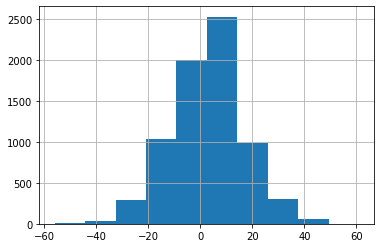

In [19]:
game['home_spread'].hist()

In [20]:
game['season'] = ''
for i in range(len(game)):
  if ((game['game_date'][i].year != 2020 and game['game_date'][i].month < 7) or (game['game_date'][i].year == 2020 and game['game_date'][i].month < 11)):
    game.loc[i,'season'] = game['game_date'][i].year
  else:
    game.loc[i,'season'] = game['game_date'][i].year + 1


In [21]:
game[game['season']=='']

,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,...,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score,home_spread,season


In [22]:
game.head()

,game_date,game_start_time,visitor_team_name,away_abbr,visitor_pts,home_team_name,home_abbr,home_pts,box_score_url,attendance,...,h_ff_orb_pct,h_ff_ft_rate,h_ff_off_rtg,load_datetime,a_g5_score,h_g5_score,a_g6_score,h_g6_score,home_spread,season
0,2021-01-18,5:00p,Phoenix Suns,PHO,104,Memphis Grizzlies,MEM,108,/boxscores/202101180MEM.html,204,...,22.0,.181,111.2,2021-02-24 21:26:16+00:00,None,None,None,None,4,2021
1,2021-01-18,3:00p,San Antonio Spurs,SAS,125,Portland Trail Blazers,POR,104,/boxscores/202101180POR.html,0,...,18.2,.178,106.7,2021-02-24 21:26:16+00:00,None,None,None,None,-21,2021
2,2021-01-18,7:30p,Dallas Mavericks,DAL,93,Toronto Raptors,TOR,116,/boxscores/202101180TOR.html,0,...,23.1,.182,117.5,2021-02-24 21:26:17+00:00,None,None,None,None,23,2021
3,2021-01-18,7:30p,Milwaukee Bucks,MIL,123,Brooklyn Nets,BRK,125,/boxscores/202101180BRK.html,0,...,18.9,.214,120.1,2021-02-24 21:26:17+00:00,None,None,None,None,2,2021
4,2021-01-18,10:00p,Golden State Warriors,GSW,115,Los Angeles Lakers,LAL,113,/boxscores/202101180LAL.html,0,...,30.8,.289,112.6,2021-02-24 21:26:18+00:00,None,None,None,None,-2,2021


In [23]:
game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   game_date          7274 non-null   object             
 1   game_start_time    7274 non-null   object             
 2   visitor_team_name  7274 non-null   object             
 3   away_abbr          7274 non-null   object             
 4   visitor_pts        7274 non-null   object             
 5   home_team_name     7274 non-null   object             
 6   home_abbr          7274 non-null   object             
 7   home_pts           7274 non-null   object             
 8   box_score_url      7274 non-null   object             
 9   attendance         7274 non-null   object             
 10  overtimes          7274 non-null   object             
 11  game_key           7274 non-null   object             
 12  a_g1_score         7274 non-null   object       

In [24]:
games_by_team_home = pd.DataFrame()
games_by_team_home['season'] = game['season']
games_by_team_home['game_key'] = game['game_key'] + 'h'
games_by_team_home['game_date'] = pd.to_datetime(game['game_date'])
games_by_team_home['team'] = game['home_team_name']
games_by_team_home['opponent'] = game['visitor_team_name']
games_by_team_home['is_home_team'] = 1
games_by_team_home['spread'] = game['home_spread']
games_by_team_home['pace'] = game['h_ff_pace']
games_by_team_home['efg_pct'] = game['h_ff_efg_pct']
games_by_team_home['tov_pct'] = game['h_ff_tov_pct']
games_by_team_home['ft_rate'] = game['h_ff_ft_rate']
games_by_team_home['off_rtg'] = game['h_ff_off_rtg']
games_by_team_home['opponent_efg_pct'] = game['a_ff_efg_pct']
games_by_team_home['opponent_tov_pct'] = game['a_ff_tov_pct']
games_by_team_home['opponent_ft_rate'] = game['a_ff_ft_rate']
games_by_team_home['opponent_off_rtg'] = game['a_ff_off_rtg']


games_by_team_home['is_win'] = ''
for i in range(len(game)):
  games_by_team_home.loc[i,'is_win'] = 1 if game['home_spread'][i].astype(int) > 0 else 0

In [25]:
games_by_team_home.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            7274 non-null   object        
 1   game_key          7274 non-null   object        
 2   game_date         7274 non-null   datetime64[ns]
 3   team              7274 non-null   object        
 4   opponent          7274 non-null   object        
 5   is_home_team      7274 non-null   int64         
 6   spread            7274 non-null   int32         
 7   pace              7274 non-null   object        
 8   efg_pct           7274 non-null   object        
 9   tov_pct           7274 non-null   object        
 10  ft_rate           7274 non-null   object        
 11  off_rtg           7274 non-null   object        
 12  opponent_efg_pct  7274 non-null   object        
 13  opponent_tov_pct  7274 non-null   object        
 14  opponent_ft_rate  7274 n

In [26]:
games_by_team_visitor = pd.DataFrame()
games_by_team_visitor ['season'] = game['season']
games_by_team_visitor ['game_key'] = game['game_key'] + 'a'
games_by_team_visitor ['game_date'] = pd.to_datetime(game['game_date'])
games_by_team_visitor ['team'] = game['visitor_team_name']
games_by_team_visitor ['opponent'] = game['home_team_name']
games_by_team_visitor ['is_home_team'] = 0
games_by_team_visitor ['spread'] = game['home_spread']*-1
games_by_team_visitor ['pace'] = game['a_ff_pace']
games_by_team_visitor ['efg_pct'] = game['a_ff_efg_pct']
games_by_team_visitor ['tov_pct'] = game['a_ff_tov_pct']
games_by_team_visitor ['ft_rate'] = game['a_ff_ft_rate']
games_by_team_visitor ['off_rtg'] = game['a_ff_off_rtg']
games_by_team_visitor['opponent_efg_pct'] = game['h_ff_efg_pct']
games_by_team_visitor['opponent_tov_pct'] = game['h_ff_tov_pct']
games_by_team_visitor['opponent_ft_rate'] = game['h_ff_ft_rate']
games_by_team_visitor['opponent_off_rtg'] = game['h_ff_off_rtg']

games_by_team_visitor['is_win'] = ''
for i in range(len(game)):
  games_by_team_visitor.loc[i,'is_win'] = 1 if game['home_spread'][i].astype(int) < 0 else 0

In [27]:
games_by_team_visitor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            7274 non-null   object        
 1   game_key          7274 non-null   object        
 2   game_date         7274 non-null   datetime64[ns]
 3   team              7274 non-null   object        
 4   opponent          7274 non-null   object        
 5   is_home_team      7274 non-null   int64         
 6   spread            7274 non-null   int32         
 7   pace              7274 non-null   object        
 8   efg_pct           7274 non-null   object        
 9   tov_pct           7274 non-null   object        
 10  ft_rate           7274 non-null   object        
 11  off_rtg           7274 non-null   object        
 12  opponent_efg_pct  7274 non-null   object        
 13  opponent_tov_pct  7274 non-null   object        
 14  opponent_ft_rate  7274 n

In [28]:
games_by_team = pd.concat([games_by_team_home,games_by_team_visitor])

In [29]:
games_by_team['is_win'].unique()

array([1, 0], dtype=object)

In [30]:
games_by_team.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14548 entries, 0 to 7273
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            14548 non-null  object        
 1   game_key          14548 non-null  object        
 2   game_date         14548 non-null  datetime64[ns]
 3   team              14548 non-null  object        
 4   opponent          14548 non-null  object        
 5   is_home_team      14548 non-null  int64         
 6   spread            14548 non-null  int32         
 7   pace              14548 non-null  object        
 8   efg_pct           14548 non-null  object        
 9   tov_pct           14548 non-null  object        
 10  ft_rate           14548 non-null  object        
 11  off_rtg           14548 non-null  object        
 12  opponent_efg_pct  14548 non-null  object        
 13  opponent_tov_pct  14548 non-null  object        
 14  opponent_ft_rate  14548

In [31]:
games_by_team[games_by_team['is_win']=='']

,season,game_key,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,is_win


In [32]:
player.head()

,game_key,game_date,h_or_a,team_abbrev,stat_period,player,player_link,player_key,reason,mp,...,ast,stl,blk,tov,pf,pts,plus_minus,player_stat_key,starter_flag,load_datetime
0,GSW20170607CLE900p,2017-06-07,a,GSW,game,Klay Thompson,/players/t/thompkl01.html,thompkl01,None,40:40,...,2,0,0,1,4,30,+3,GSW20170607CLE900p|thompkl01|game,True,2021-02-24 19:09:49+00:00
1,GSW20170607CLE900p,2017-06-07,h,CLE,game,LeBron James,/players/j/jamesle01.html,jamesle01,None,45:37,...,9,1,1,5,2,39,+7,GSW20170607CLE900p|jamesle01|game,True,2021-02-24 19:09:49+00:00
2,GSW20170607CLE900p,2017-06-07,h,CLE,game,Kyrie Irving,/players/i/irvinky01.html,irvinky01,None,44:23,...,3,0,0,2,5,38,-9,GSW20170607CLE900p|irvinky01|game,True,2021-02-24 19:09:49+00:00
3,GSW20170607CLE900p,2017-06-07,a,GSW,game,Kevin Durant,/players/d/duranke01.html,duranke01,None,40:55,...,4,1,1,3,2,31,0,GSW20170607CLE900p|duranke01|game,True,2021-02-24 19:09:49+00:00
4,MIN20171022OKC700p,2017-10-22,h,OKC,game,Russell Westbrook,/players/w/westbru01.html,westbru01,None,36:31,...,10,0,1,2,0,31,-17,MIN20171022OKC700p|westbru01|game,True,2021-02-24 19:10:57+00:00


In [33]:
player['game_key'] = player['game_key'] + player['h_or_a']

In [34]:
player = player.dropna(subset=['mp', 'plus_minus']).reset_index(drop=True)

In [35]:
player['plus_minus'] = player['plus_minus'].astype(int)

In [36]:
def convert_to_seconds(x):
  sp = int(x.split(':')[0]) * 60 + int(x.split(':')[1])
  return sp

In [37]:
player['seconds_played'] = player['mp'].apply(convert_to_seconds)

In [38]:
player['seconds_played'] = player['seconds_played'].astype(int)

In [39]:
game_player_stats = pd.DataFrame()
game_player_stats['game_key'] = player['game_key'].unique()

In [40]:
game_player_stats.head()

,game_key
0,GSW20170607CLE900pa
1,GSW20170607CLE900ph
2,MIN20171022OKC700ph
3,CHI20210106SAC1000pa
4,TOR20210106PHO900pa


In [41]:
a = player.groupby(['game_key'])['seconds_played'].sum()

In [42]:
b = player[player['starter_flag']==True].groupby(['game_key'])['seconds_played'].sum()

In [43]:
seconds = pd.merge(a, b, left_index=True, right_index=True, how='inner')

In [44]:
seconds['starter_minutes_played_proportion'] = seconds['seconds_played_y']/seconds['seconds_played_x']

In [45]:
seconds.head()

,seconds_played_x,seconds_played_y,starter_minutes_played_proportion
game_key,,,
ATL20150307PHI730pa,14400,8553,0.593958
ATL20150307PHI730ph,14400,8817,0.612292
ATL20150311DEN900pa,14400,7150,0.496528
ATL20150311DEN900ph,14400,7053,0.489792
ATL20150313PHO1000pa,14400,10095,0.701042


In [46]:
game_player_stats.set_index('game_key',inplace=True)

In [47]:
game_player_stats = pd.merge(game_player_stats,seconds['starter_minutes_played_proportion'],left_index=True,right_index=True,how='inner')

In [48]:
game_player_stats.head()

,starter_minutes_played_proportion
game_key,
GSW20170607CLE900pa,0.697153
GSW20170607CLE900ph,0.769514
MIN20171022OKC700ph,0.700069
CHI20210106SAC1000pa,0.643889
TOR20210106PHO900pa,0.694284


In [49]:
bench_pl_min = player[player['starter_flag']==False].groupby(['game_key'])['plus_minus'].sum()

In [50]:
game_player_stats = pd.merge(game_player_stats,bench_pl_min, left_index=True, right_index=True, how='inner')

In [51]:
game_player_stats = game_player_stats.rename(columns={'plus_minus':'bench_plus_minus'})

In [52]:
game_player_stats.head()

,starter_minutes_played_proportion,bench_plus_minus
game_key,,
GSW20170607CLE900pa,0.697153,-1
GSW20170607CLE900ph,0.769514,2
MIN20171022OKC700ph,0.700069,37
CHI20210106SAC1000pa,0.643889,-1
TOR20210106PHO900pa,0.694284,-43


In [53]:
games_by_team.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14548 entries, 0 to 7273
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   season            14548 non-null  object        
 1   game_key          14548 non-null  object        
 2   game_date         14548 non-null  datetime64[ns]
 3   team              14548 non-null  object        
 4   opponent          14548 non-null  object        
 5   is_home_team      14548 non-null  int64         
 6   spread            14548 non-null  int32         
 7   pace              14548 non-null  object        
 8   efg_pct           14548 non-null  object        
 9   tov_pct           14548 non-null  object        
 10  ft_rate           14548 non-null  object        
 11  off_rtg           14548 non-null  object        
 12  opponent_efg_pct  14548 non-null  object        
 13  opponent_tov_pct  14548 non-null  object        
 14  opponent_ft_rate  14548

In [54]:
games_by_team.set_index('game_key', inplace=True)

In [55]:
games_by_team = pd.merge(games_by_team,game_player_stats, left_index=True, right_index=True,how='inner')

In [56]:
games_by_team.head()

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,is_win,starter_minutes_played_proportion,bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,
ATL20150307PHI730pa,2015,2015-03-07,Atlanta Hawks,Philadelphia 76ers,0,-8,97.1,.461,18.4,.169,86.5,.437,13.5,.095,94.8,0,0.593958,-4
ATL20150307PHI730ph,2015,2015-03-07,Philadelphia 76ers,Atlanta Hawks,1,8,97.1,.437,13.5,.095,94.8,.461,18.4,.169,86.5,1,0.612292,2
ATL20150311DEN900pa,2015,2015-03-11,Atlanta Hawks,Denver Nuggets,0,-13,97.9,.475,15.5,.309,104.2,.577,17.0,.214,117.4,0,0.496528,6
ATL20150311DEN900ph,2015,2015-03-11,Denver Nuggets,Atlanta Hawks,1,13,97.9,.577,17.0,.214,117.4,.475,15.5,.309,104.2,1,0.489792,-21
ATL20150313PHO1000pa,2015,2015-03-13,Atlanta Hawks,Phoenix Suns,0,9,91.1,.518,11.1,.120,105.3,.474,17.1,.167,95.5,1,0.701042,34


In [57]:
game_player_stats

,starter_minutes_played_proportion,bench_plus_minus
game_key,,
GSW20170607CLE900pa,0.697153,-1
GSW20170607CLE900ph,0.769514,2
MIN20171022OKC700ph,0.700069,37
CHI20210106SAC1000pa,0.643889,-1
TOR20210106PHO900pa,0.694284,-43
...,...,...
ORL20191215NOP330pa,0.638194,37
HOU20161116OKC800pa,0.718958,-1
CHO20181229WAS700ph,0.769792,13


In [58]:
game_player_stats_opponent = game_player_stats.copy()

In [59]:
game_player_stats_opponent.reset_index(drop=False, inplace=True)

In [60]:
def switch_key(key):
  new_key = key[:-1] + ('h' if key[-1] == 'a' else 'a')
  return new_key

In [61]:
game_player_stats_opponent['game_key'] = game_player_stats_opponent['game_key'].apply(switch_key)

In [62]:
game_player_stats_opponent = game_player_stats_opponent.rename(columns={'starter_minutes_played_proportion':'opponnent_starter_minutes_played_proportion','bench_plus_minus':'opponent_bench_plus_minus'})

In [63]:
game_player_stats_opponent.set_index('game_key', inplace=True)

In [64]:
games_by_team = pd.merge(games_by_team,game_player_stats_opponent,left_index=True,right_index=True,how='inner')

In [65]:
games_by_team.head()

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,is_win,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,
ATL20150307PHI730pa,2015,2015-03-07,Atlanta Hawks,Philadelphia 76ers,0,-8,97.1,.461,18.4,.169,86.5,.437,13.5,.095,94.8,0,0.593958,-4,0.612292,2
ATL20150307PHI730ph,2015,2015-03-07,Philadelphia 76ers,Atlanta Hawks,1,8,97.1,.437,13.5,.095,94.8,.461,18.4,.169,86.5,1,0.612292,2,0.593958,-4
ATL20150311DEN900pa,2015,2015-03-11,Atlanta Hawks,Denver Nuggets,0,-13,97.9,.475,15.5,.309,104.2,.577,17.0,.214,117.4,0,0.496528,6,0.489792,-21
ATL20150311DEN900ph,2015,2015-03-11,Denver Nuggets,Atlanta Hawks,1,13,97.9,.577,17.0,.214,117.4,.475,15.5,.309,104.2,1,0.489792,-21,0.496528,6
ATL20150313PHO1000pa,2015,2015-03-13,Atlanta Hawks,Phoenix Suns,0,9,91.1,.518,11.1,.120,105.3,.474,17.1,.167,95.5,1,0.701042,34,0.720694,-31


In [66]:
games_by_team.loc[(games_by_team['team']=='Atlanta Hawks') & (games_by_team['season']==2019)]

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,ft_rate,off_rtg,opponent_efg_pct,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,is_win,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,
ATL20181017NYK730pa,2019,2018-10-17,Atlanta Hawks,New York Knicks,0,-19,113.5,.511,19.7,.167,94.3,.515,11.8,.242,111.0,0,0.587986,-45,0.523958,49
ATL20181019MEM800pa,2019,2018-10-19,Atlanta Hawks,Memphis Grizzlies,0,-14,106.0,.578,16.1,.253,110.4,.623,13.8,.370,123.6,0,0.519444,-26,0.495208,-49
ATL20181021CLE600pa,2019,2018-10-21,Atlanta Hawks,Cleveland Cavaliers,0,22,106.0,.602,10.1,.153,125.5,.515,14.6,.091,104.7,1,0.585069,57,0.642569,-79
ATL20181029PHI700pa,2019,2018-10-29,Atlanta Hawks,Philadelphia 76ers,0,-21,105.5,.415,11.2,.149,87.2,.485,15.1,.172,107.1,0,0.508819,-39,0.579722,39
ATL20181030CLE700pa,2019,2018-10-30,Atlanta Hawks,Cleveland Cavaliers,0,-22,105.7,.628,19.7,.134,107.8,.572,10.7,.367,128.6,0,0.566806,-14,0.595486,-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TOR20181121ATL730ph,2019,2018-11-21,Atlanta Hawks,Toronto Raptors,1,-16,99.7,.505,8.2,.151,108.3,.594,14.5,.189,124.3,0,0.498333,4,0.660764,-18
TOR20190207ATL730ph,2019,2019-02-07,Atlanta Hawks,Toronto Raptors,1,-18,96.9,.550,15.7,.163,104.2,.534,7.3,.299,122.7,0,0.625139,-1,0.697083,34
UTA20190321ATL730ph,2019,2019-03-21,Atlanta Hawks,Utah Jazz,1,3,102.8,.580,14.1,.184,113.8,.511,12.5,.191,110.9,1,0.631597,13,0.645208,-18


In [67]:
def generate_streak_info(data,column):
    """
    Parameters
    ----------
    data:
      Dataframe with a specific column to generate streak data

    column:
      Stirng with specific column name to generate streak info

    Returns
    -------

    data_with_streak_counter:
        The original dataframe with a new column
        `streak_counter_[column]` containing integers with 
        counts for each streak.
    """
    
    data['start_of_streak'] = data[column].ne(data[column].shift())
    data['streak_id'] = data.start_of_streak.cumsum()
    data[f'streak_counter_{column}'] = data.groupby('streak_id').cumcount() + 1
    data_with_streak_counter = data.drop(columns = ['start_of_streak','streak_id'] )
    return data_with_streak_counter

In [68]:
testing = games_by_team.loc[(games_by_team['team']=='Atlanta Hawks') & (games_by_team['season']==2019)].sort_values(by=['game_date'])
testing2 = games_by_team.loc[(games_by_team['team']=='Washington Wizards') & (games_by_team['season']==2019)].sort_values(by=['game_date'])

In [69]:
testing = generate_streak_info(testing,'is_win')
testing2 = generate_streak_info(testing2,'is_win')

In [70]:
# Make negative streak if losing streak, positive if winning streak
testing['streak_counter_is_win'] = [x * -1 if y == 0 else x for x,y in zip(testing['streak_counter_is_win'],testing['is_win'])]
testing['incoming_is_win_streak'] = testing['streak_counter_is_win'].shift(fill_value=0)
testing2['streak_counter_is_win'] = [x * -1 if y == 0 else x for x,y in zip(testing2['streak_counter_is_win'],testing2['is_win'])]
testing2['incoming_is_win_streak'] = testing2['streak_counter_is_win'].shift(fill_value=0)


In [71]:
test = pd.concat([testing, testing2])

In [72]:
test.head()

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,ft_rate,...,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,is_win,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus,streak_counter_is_win,incoming_is_win_streak
game_key,,,,,,,,,,,,,,,,,,,,,
ATL20181017NYK730pa,2019,2018-10-17,Atlanta Hawks,New York Knicks,0,-19,113.5,.511,19.7,.167,...,11.8,.242,111.0,0,0.587986,-45,0.523958,49,-1,0
ATL20181019MEM800pa,2019,2018-10-19,Atlanta Hawks,Memphis Grizzlies,0,-14,106.0,.578,16.1,.253,...,13.8,.370,123.6,0,0.519444,-26,0.495208,-49,-2,-1
ATL20181021CLE600pa,2019,2018-10-21,Atlanta Hawks,Cleveland Cavaliers,0,22,106.0,.602,10.1,.153,...,14.6,.091,104.7,1,0.585069,57,0.642569,-79,1,-2
DAL20181024ATL700ph,2019,2018-10-24,Atlanta Hawks,Dallas Mavericks,1,7,108.1,.489,12.5,.242,...,14.2,.176,96.2,1,0.611806,2,0.677431,39,2,1
CHI20181027ATL730ph,2019,2018-10-27,Atlanta Hawks,Chicago Bulls,1,-12,101.7,.393,18.9,.226,...,18.2,.157,95.3,0,0.566250,25,0.540833,49,-1,2


In [73]:
test.loc[(test['team']=='Washington Wizards') & (test['season']==2019)]

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,ft_rate,...,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,is_win,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus,streak_counter_is_win,incoming_is_win_streak
game_key,,,,,,,,,,,,,,,,,,,,,
MIA20181018WAS800ph,2019,2018-10-18,Washington Wizards,Miami Heat,1,-1,101.9,.512,12.5,.358,...,12.5,.258,110.8,0,0.554514,-8,0.652639,13,-1,0
TOR20181020WAS700ph,2019,2018-10-20,Washington Wizards,Toronto Raptors,1,-4,102.0,.489,9.6,.292,...,14.1,.330,114.7,0,0.596111,-44,0.570972,-7,-2,-1
WAS20181022POR1000pa,2019,2018-10-22,Washington Wizards,Portland Trail Blazers,0,1,107.4,.486,7.6,.164,...,13.5,.250,104.6,1,0.592327,0,0.598113,-2,1,-2
WAS20181024GSW1030pa,2019,2018-10-24,Washington Wizards,Golden State Warriors,0,-22,106.7,.516,10.2,.280,...,12.7,.250,134.9,0,0.433194,-49,0.551528,32,-1,1
WAS20181026SAC1000pa,2019,2018-10-26,Washington Wizards,Sacramento Kings,0,-4,108.9,.547,17.9,.209,...,14.6,.147,106.5,0,0.636111,11,0.635000,-48,-2,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WAS20190331DEN800pa,2019,2019-03-31,Washington Wizards,Denver Nuggets,0,5,99.6,.435,9.0,.163,...,9.8,.140,90.4,1,0.738333,12,0.609514,-31,1,-1
CHI20190403WAS700ph,2019,2019-04-03,Washington Wizards,Chicago Bulls,1,-1,107.8,.490,10.0,.196,...,17.0,.156,106.7,0,0.609514,0,0.538403,11,-1,1
SAS20190405WAS700ph,2019,2019-04-05,Washington Wizards,San Antonio Spurs,1,-17,94.3,.528,8.4,.216,...,8.3,.187,136.8,0,0.655694,-48,0.585556,16,-2,-1


In [74]:
testing = games_by_team.loc[(games_by_team['team']=='Atlanta Hawks') & (games_by_team['season']==2019)].sort_values(by=['game_date'])

In [75]:
testing['pace'].unique()

array(['113.5', '106.0', '108.1', '101.7', '105.5', '105.7', '112.9',
       '100.5', '108.0', '101.5', '102.9', '103.9', '96.8', '106.2',
       '107.4', '107.1', '99.7', '106.6', '101.6', '106.7', '104.0',
       '107.5', '110.6', '101.3', '106.5', '101.2', '102.8', '100.6',
       '101.8', '102.3', '99.8', '96.9', '99.6', '112.3', '97.3', '103.8',
       '104.8', '98.1', '110.2', '104.9', '101.1', '99.3', '97.8', '98.0',
       '105.2', '105.4', '100.4', '98.2', '95.7', '111.4', '97.0', '96.2',
       '100.8', '102.6', '97.6', '104.4', '104.6', '103.0', '98.7',
       '105.9', '100.9', '110.9', '107.7'], dtype=object)

In [76]:
testing['pace'] = testing['pace'].astype(float)

In [77]:
# Set W to number of days desired for moving average
W = 10
weights = np.arange(1,W+1)

In [78]:
testing['pace'].rolling(10).apply(lambda pace: np.dot(pace, weights)/weights.sum(), raw=True)

game_key
ATL20181017NYK730pa           NaN
ATL20181019MEM800pa           NaN
ATL20181021CLE600pa           NaN
DAL20181024ATL700ph           NaN
CHI20181027ATL730ph           NaN
                          ...    
ATL20190402SAS830pa    104.201818
PHI20190403ATL730ph    103.758182
ATL20190405ORL700pa    105.016364
ATL20190407MIL700pa    105.614545
IND20190410ATL800ph    106.127273
Name: pace, Length: 82, dtype: float64

In [79]:
def create_linear_weighted_moving_average(data,column,W):
    """
    Parameters
    ----------
    data:
      Dataframe with a specific column to generate weighted moving average.

    column:
      Stirng with specific column name to generate weighted moving average info.
      Column must be ready to be converted to float data type.

    Returns
    -------

    data_with_moving_average:
        The original dataframe with a new column
        `wma_[W]_[column]` containing float values with weighted moving average
        values for the provided value with a weight of W.
    """  
    data_with_moving_average = data.copy()
    data_with_moving_average[column] = data_with_moving_average[column].astype(float)
    weights = np.arange(1,W+1) 
    data_with_moving_average[f'wma_{W}_{column}'] = data_with_moving_average[column].rolling(W).apply(lambda col: np.dot(col, weights)/weights.sum(), raw=True)
    return data_with_moving_average

In [80]:
testing4 = create_linear_weighted_moving_average(testing,'efg_pct',10)

In [81]:
testing4 = create_linear_weighted_moving_average(testing4,'bench_plus_minus',10)

In [82]:
testing4.head()

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,ft_rate,...,opponent_tov_pct,opponent_ft_rate,opponent_off_rtg,is_win,starter_minutes_played_proportion,bench_plus_minus,opponnent_starter_minutes_played_proportion,opponent_bench_plus_minus,wma_10_efg_pct,wma_10_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,,
ATL20181017NYK730pa,2019,2018-10-17,Atlanta Hawks,New York Knicks,0,-19,113.5,0.511,19.7,.167,...,11.8,.242,111.0,0,0.587986,-45.0,0.523958,49,NaN,NaN
ATL20181019MEM800pa,2019,2018-10-19,Atlanta Hawks,Memphis Grizzlies,0,-14,106.0,0.578,16.1,.253,...,13.8,.370,123.6,0,0.519444,-26.0,0.495208,-49,NaN,NaN
ATL20181021CLE600pa,2019,2018-10-21,Atlanta Hawks,Cleveland Cavaliers,0,22,106.0,0.602,10.1,.153,...,14.6,.091,104.7,1,0.585069,57.0,0.642569,-79,NaN,NaN
DAL20181024ATL700ph,2019,2018-10-24,Atlanta Hawks,Dallas Mavericks,1,7,108.1,0.489,12.5,.242,...,14.2,.176,96.2,1,0.611806,2.0,0.677431,39,NaN,NaN
CHI20181027ATL730ph,2019,2018-10-27,Atlanta Hawks,Chicago Bulls,1,-12,101.7,0.393,18.9,.226,...,18.2,.157,95.3,0,0.566250,25.0,0.540833,49,NaN,NaN


In [83]:
games_by_team_with_streak = pd.DataFrame()
wma_columns = ['pace',
       'efg_pct', 'tov_pct', 'ft_rate', 'off_rtg',
       'opponent_efg_pct', 'opponent_tov_pct', 'opponent_ft_rate',
       'opponent_off_rtg', 'starter_minutes_played_proportion',
       'bench_plus_minus', 'opponnent_starter_minutes_played_proportion',
       'opponent_bench_plus_minus']
W = 10
for team in games_by_team['team'].unique():
  team_games = games_by_team.loc[games_by_team['team']==team].sort_values(by='game_date')
  team_games = generate_streak_info(team_games,'is_win')
  team_games['streak_counter_is_win'] = [x * -1 if y == 0 else x for x,y in zip(team_games['streak_counter_is_win'],team_games['is_win'])]
  team_games['incoming_is_win_streak'] = team_games['streak_counter_is_win'].shift()
  for col in wma_columns:
    team_games = create_linear_weighted_moving_average(team_games,col,W)
    team_games[f'incoming_wma_{W}_{col}'] = team_games[f'wma_{W}_{col}'].shift()
  games_by_team_with_streak = pd.concat([games_by_team_with_streak, team_games])

In [84]:
games_by_team = games_by_team_with_streak.copy()

In [85]:
games_by_team.head(12)

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,ft_rate,...,wma_10_opponent_off_rtg,incoming_wma_10_opponent_off_rtg,wma_10_starter_minutes_played_proportion,incoming_wma_10_starter_minutes_played_proportion,wma_10_bench_plus_minus,incoming_wma_10_bench_plus_minus,wma_10_opponnent_starter_minutes_played_proportion,incoming_wma_10_opponnent_starter_minutes_played_proportion,wma_10_opponent_bench_plus_minus,incoming_wma_10_opponent_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,,
HOU20150303ATL730ph,2015,2015-03-03,Atlanta Hawks,Houston Rockets,1,8,97.6,0.500,13.6,0.209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLE20150306ATL730ph,2015,2015-03-06,Atlanta Hawks,Cleveland Cavaliers,1,9,88.9,0.548,11.6,0.167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150307PHI730pa,2015,2015-03-07,Atlanta Hawks,Philadelphia 76ers,0,-8,97.1,0.461,18.4,0.169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAC20150309ATL730ph,2015,2015-03-09,Atlanta Hawks,Sacramento Kings,1,25,89.7,0.716,12.5,0.045,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150311DEN900pa,2015,2015-03-11,Atlanta Hawks,Denver Nuggets,0,-13,97.9,0.475,15.5,0.309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150313PHO1000pa,2015,2015-03-13,Atlanta Hawks,Phoenix Suns,0,9,91.1,0.518,11.1,0.120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150315LAL930pa,2015,2015-03-15,Atlanta Hawks,Los Angeles Lakers,0,5,89.4,0.480,10.2,0.237,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150316SAC1000pa,2015,2015-03-16,Atlanta Hawks,Sacramento Kings,0,7,99.3,0.524,11.0,0.262,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150318GSW1030pa,2015,2015-03-18,Atlanta Hawks,Golden State Warriors,0,-19,97.3,0.402,13.0,0.287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
games_by_team.columns

Index(['season', 'game_date', 'team', 'opponent', 'is_home_team', 'spread',
       'pace', 'efg_pct', 'tov_pct', 'ft_rate', 'off_rtg', 'opponent_efg_pct',
       'opponent_tov_pct', 'opponent_ft_rate', 'opponent_off_rtg', 'is_win',
       'starter_minutes_played_proportion', 'bench_plus_minus',
       'opponnent_starter_minutes_played_proportion',
       'opponent_bench_plus_minus', 'streak_counter_is_win',
       'incoming_is_win_streak', 'wma_10_pace', 'incoming_wma_10_pace',
       'wma_10_efg_pct', 'incoming_wma_10_efg_pct', 'wma_10_tov_pct',
       'incoming_wma_10_tov_pct', 'wma_10_ft_rate', 'incoming_wma_10_ft_rate',
       'wma_10_off_rtg', 'incoming_wma_10_off_rtg', 'wma_10_opponent_efg_pct',
       'incoming_wma_10_opponent_efg_pct', 'wma_10_opponent_tov_pct',
       'incoming_wma_10_opponent_tov_pct', 'wma_10_opponent_ft_rate',
       'incoming_wma_10_opponent_ft_rate', 'wma_10_opponent_off_rtg',
       'incoming_wma_10_opponent_off_rtg',
       'wma_10_starter_minutes_playe

In [87]:
model_game_data = games_by_team.copy()

In [88]:
model_game_data.head()

,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,ft_rate,...,wma_10_opponent_off_rtg,incoming_wma_10_opponent_off_rtg,wma_10_starter_minutes_played_proportion,incoming_wma_10_starter_minutes_played_proportion,wma_10_bench_plus_minus,incoming_wma_10_bench_plus_minus,wma_10_opponnent_starter_minutes_played_proportion,incoming_wma_10_opponnent_starter_minutes_played_proportion,wma_10_opponent_bench_plus_minus,incoming_wma_10_opponent_bench_plus_minus
game_key,,,,,,,,,,,,,,,,,,,,,
HOU20150303ATL730ph,2015,2015-03-03,Atlanta Hawks,Houston Rockets,1,8,97.6,0.500,13.6,0.209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CLE20150306ATL730ph,2015,2015-03-06,Atlanta Hawks,Cleveland Cavaliers,1,9,88.9,0.548,11.6,0.167,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150307PHI730pa,2015,2015-03-07,Atlanta Hawks,Philadelphia 76ers,0,-8,97.1,0.461,18.4,0.169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SAC20150309ATL730ph,2015,2015-03-09,Atlanta Hawks,Sacramento Kings,1,25,89.7,0.716,12.5,0.045,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATL20150311DEN900pa,2015,2015-03-11,Atlanta Hawks,Denver Nuggets,0,-13,97.9,0.475,15.5,0.309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
model_game_data = games_by_team.dropna(subset=['incoming_wma_10_pace'])

In [90]:
model_game_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14248 entries, SAS20150322ATL300ph to WAS20210225DEN900pa
Data columns (total 48 columns):
 #   Column                                                       Non-Null Count  Dtype         
---  ------                                                       --------------  -----         
 0   season                                                       14248 non-null  object        
 1   game_date                                                    14248 non-null  datetime64[ns]
 2   team                                                         14248 non-null  object        
 3   opponent                                                     14248 non-null  object        
 4   is_home_team                                                 14248 non-null  int64         
 5   spread                                                       14248 non-null  int32         
 6   pace                                                         14248 non-null  float6

In [91]:
model_game_data['is_win'].unique()

array([0, 1], dtype=object)

In [92]:
model_game_data['season'].unique()

array([2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype=object)

In [93]:
model_game_data = model_game_data.astype({'season': int, 'is_win': int})

In [94]:
model_game_data.reset_index(drop=False,inplace=True)

In [95]:
model_game_data.head()

,game_key,season,game_date,team,opponent,is_home_team,spread,pace,efg_pct,tov_pct,...,wma_10_opponent_off_rtg,incoming_wma_10_opponent_off_rtg,wma_10_starter_minutes_played_proportion,incoming_wma_10_starter_minutes_played_proportion,wma_10_bench_plus_minus,incoming_wma_10_bench_plus_minus,wma_10_opponnent_starter_minutes_played_proportion,incoming_wma_10_opponnent_starter_minutes_played_proportion,wma_10_opponent_bench_plus_minus,incoming_wma_10_opponent_bench_plus_minus
0,SAS20150322ATL300ph,2015,2015-03-22,Atlanta Hawks,San Antonio Spurs,1,-19,93.5,0.550,17.8,...,113.116364,110.569091,0.632830,0.632889,9.581818,8.836364,0.597926,0.592935,1.563636,4.963636
1,ATL20150325ORL700pa,2015,2015-03-25,Atlanta Hawks,Orlando Magic,0,12,91.8,0.489,12.1,...,109.509091,113.116364,0.648553,0.632830,7.327273,9.581818,0.621130,0.597926,3.563636,1.563636
2,MIA20150327ATL730ph,2015,2015-03-27,Atlanta Hawks,Miami Heat,1,13,92.4,0.556,16.2,...,106.716364,109.509091,0.656517,0.648553,7.436364,7.327273,0.622696,0.621130,5.018182,3.563636
3,ATL20150328CHO700pa,2015,2015-03-28,Atlanta Hawks,Charlotte Hornets,0,-15,90.9,0.517,9.8,...,110.047273,106.716364,0.657248,0.656517,1.654545,7.436364,0.622073,0.622696,7.127273,5.018182
4,MIL20150330ATL730ph,2015,2015-03-30,Atlanta Hawks,Milwaukee Bucks,1,13,83.5,0.513,10.9,...,109.370909,110.047273,0.665779,0.657248,3.327273,1.654545,0.632917,0.622073,3.309091,7.127273


In [96]:
model_game_data.columns

Index(['game_key', 'season', 'game_date', 'team', 'opponent', 'is_home_team',
       'spread', 'pace', 'efg_pct', 'tov_pct', 'ft_rate', 'off_rtg',
       'opponent_efg_pct', 'opponent_tov_pct', 'opponent_ft_rate',
       'opponent_off_rtg', 'is_win', 'starter_minutes_played_proportion',
       'bench_plus_minus', 'opponnent_starter_minutes_played_proportion',
       'opponent_bench_plus_minus', 'streak_counter_is_win',
       'incoming_is_win_streak', 'wma_10_pace', 'incoming_wma_10_pace',
       'wma_10_efg_pct', 'incoming_wma_10_efg_pct', 'wma_10_tov_pct',
       'incoming_wma_10_tov_pct', 'wma_10_ft_rate', 'incoming_wma_10_ft_rate',
       'wma_10_off_rtg', 'incoming_wma_10_off_rtg', 'wma_10_opponent_efg_pct',
       'incoming_wma_10_opponent_efg_pct', 'wma_10_opponent_tov_pct',
       'incoming_wma_10_opponent_tov_pct', 'wma_10_opponent_ft_rate',
       'incoming_wma_10_opponent_ft_rate', 'wma_10_opponent_off_rtg',
       'incoming_wma_10_opponent_off_rtg',
       'wma_10_starter_m

In [97]:
most_recent_game = model_game_data.sort_values('game_date').drop_duplicates(['team'],keep='last')

In [98]:
most_recent_game = most_recent_game[['season', 'game_date', 'team','streak_counter_is_win',
       'wma_10_pace', 'wma_10_efg_pct', 'wma_10_tov_pct', 'wma_10_ft_rate',
       'wma_10_off_rtg', 'wma_10_opponent_efg_pct', 'wma_10_opponent_tov_pct',
       'wma_10_opponent_ft_rate', 'wma_10_opponent_off_rtg',
       'wma_10_starter_minutes_played_proportion', 'wma_10_bench_plus_minus',
       'wma_10_opponnent_starter_minutes_played_proportion',
       'wma_10_opponent_bench_plus_minus']]

In [99]:
most_recent_game.reset_index(drop=True, inplace=True)

In [100]:
most_recent_game.set_index('team', inplace=True)

In [101]:
docs = most_recent_game.to_dict(orient='index')

In [102]:
most_recent_game.index.unique()

Index(['Cleveland Cavaliers', 'Minnesota Timberwolves', 'San Antonio Spurs',
       'Dallas Mavericks', 'Brooklyn Nets', 'New Orleans Pelicans',
       'Milwaukee Bucks', 'Denver Nuggets', 'Washington Wizards',
       'New York Knicks', 'Philadelphia 76ers', 'Orlando Magic',
       'Los Angeles Clippers', 'Phoenix Suns', 'Indiana Pacers',
       'Los Angeles Lakers', 'Toronto Raptors', 'Portland Trail Blazers',
       'Atlanta Hawks', 'Sacramento Kings', 'Golden State Warriors',
       'Oklahoma City Thunder', 'Utah Jazz', 'Chicago Bulls',
       'Charlotte Hornets', 'Boston Celtics', 'Detroit Pistons', 'Miami Heat',
       'Memphis Grizzlies', 'Houston Rockets'],
      dtype='object', name='team')

In [103]:
docs['Cleveland Cavaliers']

{'season': 2021,
 'game_date': Timestamp('2021-02-24 00:00:00'),
 'streak_counter_is_win': 2,
 'wma_10_pace': 96.35636363636362,
 'wma_10_efg_pct': 0.5344363636363636,
 'wma_10_tov_pct': 13.940000000000001,
 'wma_10_ft_rate': 0.1756909090909091,
 'wma_10_off_rtg': 110.65272727272726,
 'wma_10_opponent_efg_pct': 0.577309090909091,
 'wma_10_opponent_tov_pct': 10.814545454545454,
 'wma_10_opponent_ft_rate': 0.21478181818181818,
 'wma_10_opponent_off_rtg': 121.0490909090909,
 'wma_10_starter_minutes_played_proportion': 0.6795252525252525,
 'wma_10_bench_plus_minus': -8.8,
 'wma_10_opponnent_starter_minutes_played_proportion': 0.625125,
 'wma_10_opponent_bench_plus_minus': 8.745454545454546}

In [104]:
#!pip install google-cloud-secret-manager

In [125]:
credentials

'C:\\GCP\\nba-predictions-dev-d76075f0a064.json'

In [127]:
default_app = firebase_admin.initialize_app()

In [128]:
db = firestore.client()

In [130]:
for team in most_recent_game.index.unique():
    doc_ref = db.collection('team_model_data').document(team)
    doc_ref.set(docs[team])
    print(docs[team])

{'season': 2021, 'game_date': Timestamp('2021-02-24 00:00:00'), 'streak_counter_is_win': 2, 'wma_10_pace': 96.35636363636362, 'wma_10_efg_pct': 0.5344363636363636, 'wma_10_tov_pct': 13.940000000000001, 'wma_10_ft_rate': 0.1756909090909091, 'wma_10_off_rtg': 110.65272727272726, 'wma_10_opponent_efg_pct': 0.577309090909091, 'wma_10_opponent_tov_pct': 10.814545454545454, 'wma_10_opponent_ft_rate': 0.21478181818181818, 'wma_10_opponent_off_rtg': 121.0490909090909, 'wma_10_starter_minutes_played_proportion': 0.6795252525252525, 'wma_10_bench_plus_minus': -8.8, 'wma_10_opponnent_starter_minutes_played_proportion': 0.625125, 'wma_10_opponent_bench_plus_minus': 8.745454545454546}
{'season': 2021, 'game_date': Timestamp('2021-02-24 00:00:00'), 'streak_counter_is_win': -6, 'wma_10_pace': 99.90727272727274, 'wma_10_efg_pct': 0.5101818181818182, 'wma_10_tov_pct': 12.383636363636365, 'wma_10_ft_rate': 0.15216363636363636, 'wma_10_off_rtg': 106.68363636363637, 'wma_10_opponent_efg_pct': 0.5544363636

{'season': 2021, 'game_date': Timestamp('2021-02-26 00:00:00'), 'streak_counter_is_win': -2, 'wma_10_pace': 99.0909090909091, 'wma_10_efg_pct': 0.5162181818181818, 'wma_10_tov_pct': 10.752727272727272, 'wma_10_ft_rate': 0.23434545454545452, 'wma_10_off_rtg': 111.58181818181818, 'wma_10_opponent_efg_pct': 0.5146727272727273, 'wma_10_opponent_tov_pct': 11.836363636363636, 'wma_10_opponent_ft_rate': 0.2517272727272727, 'wma_10_opponent_off_rtg': 112.07636363636364, 'wma_10_starter_minutes_played_proportion': 0.6860698494377739, 'wma_10_bench_plus_minus': 4.781818181818182, 'wma_10_opponnent_starter_minutes_played_proportion': 0.6532704640747095, 'wma_10_opponent_bench_plus_minus': 5.781818181818182}
{'season': 2021, 'game_date': Timestamp('2021-02-26 00:00:00'), 'streak_counter_is_win': 1, 'wma_10_pace': 96.94181818181819, 'wma_10_efg_pct': 0.5034181818181819, 'wma_10_tov_pct': 12.972727272727273, 'wma_10_ft_rate': 0.18290909090909088, 'wma_10_off_rtg': 105.05636363636363, 'wma_10_opponen

{'season': 2021, 'game_date': Timestamp('2021-02-26 00:00:00'), 'streak_counter_is_win': 5, 'wma_10_pace': 96.61454545454546, 'wma_10_efg_pct': 0.5431090909090909, 'wma_10_tov_pct': 12.350909090909092, 'wma_10_ft_rate': 0.21743636363636365, 'wma_10_off_rtg': 114.75090909090909, 'wma_10_opponent_efg_pct': 0.5427272727272727, 'wma_10_opponent_tov_pct': 12.901818181818182, 'wma_10_opponent_ft_rate': 0.18841818181818182, 'wma_10_opponent_off_rtg': 110.4090909090909, 'wma_10_starter_minutes_played_proportion': 0.691313750714694, 'wma_10_bench_plus_minus': -0.2727272727272727, 'wma_10_opponnent_starter_minutes_played_proportion': 0.6525189155708023, 'wma_10_opponent_bench_plus_minus': -6.963636363636364}
{'season': 2021, 'game_date': Timestamp('2021-02-26 00:00:00'), 'streak_counter_is_win': -1, 'wma_10_pace': 99.06181818181817, 'wma_10_efg_pct': 0.5047090909090909, 'wma_10_tov_pct': 9.952727272727275, 'wma_10_ft_rate': 0.17214545454545455, 'wma_10_off_rtg': 108.98181818181818, 'wma_10_oppon

In [137]:

docs = db.collection('team_model_data').stream()
teams = []
for doc in docs:
    teams.append(doc.id)
    #print(f'{doc.id} => {doc.to_dict()}')

In [138]:
teams

['Atlanta Hawks',
 'Boston Celtics',
 'Brooklyn Nets',
 'Charlotte Hornets',
 'Chicago Bulls',
 'Cleveland Cavaliers',
 'Dallas Mavericks',
 'Denver Nuggets',
 'Detroit Pistons',
 'Golden State Warriors',
 'Houston Rockets',
 'Indiana Pacers',
 'Los Angeles Clippers',
 'Los Angeles Lakers',
 'Memphis Grizzlies',
 'Miami Heat',
 'Milwaukee Bucks',
 'Minnesota Timberwolves',
 'New Orleans Pelicans',
 'New York Knicks',
 'Oklahoma City Thunder',
 'Orlando Magic',
 'Philadelphia 76ers',
 'Phoenix Suns',
 'Portland Trail Blazers',
 'Sacramento Kings',
 'San Antonio Spurs',
 'Toronto Raptors',
 'Utah Jazz',
 'Washington Wizards']

In [135]:
doc_ref = db.collection('team_model_data').document('Atlanta Hawks')

doc = doc_ref.get().to_dict()

In [136]:
doc

{'wma_10_starter_minutes_played_proportion': 0.6474386835751079,
 'wma_10_opponent_bench_plus_minus': 3.109090909090909,
 'wma_10_ft_rate': 0.22692727272727276,
 'wma_10_opponent_tov_pct': 10.976363636363637,
 'wma_10_opponent_efg_pct': 0.5832727272727273,
 'wma_10_opponent_ft_rate': 0.18387272727272727,
 'wma_10_bench_plus_minus': -2.4545454545454546,
 'game_date': DatetimeWithNanoseconds(2021, 2, 26, 0, 0, tzinfo=<UTC>),
 'wma_10_off_rtg': 120.48909090909092,
 'wma_10_efg_pct': 0.5536545454545455,
 'streak_counter_is_win': -1,
 'wma_10_tov_pct': 11.136363636363637,
 'wma_10_opponnent_starter_minutes_played_proportion': 0.6307753982837334,
 'wma_10_pace': 96.31818181818181,
 'wma_10_opponent_off_rtg': 121.19454545454545,
 'season': 2021}

In [ ]:

if doc.exists:
    print(f'Document data: {doc.to_dict()}')
else:
    print(u'No such document!')

In [ ]:
client = bigquery.Client(project=my_project_id)

In [ ]:
model_table_name = 'nba.model_game'

In [ ]:

#Publish model data
job_config = bigquery.LoadJobConfig()
job_config.autodetect='True'
job_config.create_disposition = 'CREATE_IF_NEEDED'
#Truncate for now 
job_config.write_disposition = 'WRITE_TRUNCATE'
job_config.time_partitioning = bigquery.TimePartitioning(
    type_=bigquery.TimePartitioningType.DAY,
    field="game_date")
## Set schema for specific columns where more information is needed (e.g. not NULLABLE or specific date/time)
job_config.schema = [
    bigquery.SchemaField('game_key','STRING', 'REQUIRED'),
    bigquery.SchemaField('team','STRING', 'REQUIRED'),
    bigquery.SchemaField('opponent','STRING', 'REQUIRED'),
    bigquery.SchemaField('game_date','DATE'),
]
job_model = client.load_table_from_dataframe(model_game_data, model_table_name, job_config=job_config)


In [ ]:
model_result = job_model.result()
model_message = (
    f'Job ID: {model_result.job_id} '
    f'was started {model_result.started} '
    f'and ended {model_result.ended} '
    f'loading {model_result.output_rows} row(s) '
    f'to {model_result.destination}')


In [ ]:
print(model_message)

Job ID: 5421b832-c2b4-4ddb-847d-eadd79edc9f1 was started 2021-02-27 04:28:24.532000+00:00 and ended 2021-02-27 04:28:35.493000+00:00 loading 14230 row(s) to TableReference(DatasetReference('nba-predictions-dev', 'nba'), 'model_game')
